# Image formation

In [1]:
import matplotlib.image as mpimg
from matplotlib import pyplot as plt
import numpy as np
import cv2

In [2]:
img = mpimg.imread("Thomas.png")

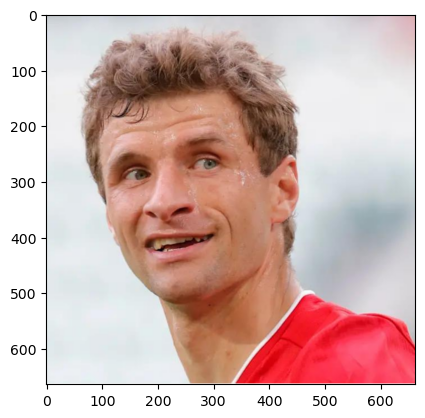

In [3]:
plt.imshow(img)

## 2D Transformations

### Translation

In [4]:
def get_homogene_coords(image):
    xx, yy = np.mgrid[:image.shape[0], :image.shape[1]]
    ww = np.ones(xx.shape)
    return np.array([xx, yy, ww]).astype(int).transpose(1, 2, 0) #.transpose(1, 2, 0)  # Returns array with shape (x, y, 3)


def get_homogene_coords_from_inhomogene(inhomog_coors):
    added_ones = np.ones((list(inhomog_coors[..., 0].shape) + [1]))
    return np.concatenate([inhomog_coors, added_ones], axis=-1)

In [5]:
def get_inhomogene_from_homogene_coords(coords):
    """
    Get two-dimensional coordinates from three-dimensional
    """
    return (coords[..., :-1] / coords[..., -1:]).astype(int)

In [6]:
def swap_columns_last_dim(arr, col1, col2):
    temp = np.copy(arr[..., col1])
    arr[..., col1] = arr[...,  col2]
    arr[..., col2] = temp
    return arr


def cartesian_from_image_coords(image_coords):
    """
    Image coordinates have x-axis top-down and y-axis left-right

    sensible cartesian coordinates have x-axis left-right and y-axis bottom up
    """

    image_coords_swapped = swap_columns_last_dim(image_coords, 0, 1)
    
    x_shape = image_coords.shape[0]
    image_coords_swapped[..., 1] = (x_shape - 1) - image_coords_swapped[..., 1]

    return image_coords_swapped


def image_coords_from_cartesian(cartesian):
    """
    Sensible cartesian coordinates have x-axis left-right and y-axis bottom up

    Image coordinates have x-axis top-down and y-axis left-right
    """

    image_coords_swapped = swap_columns_last_dim(cartesian, 0, 1)
    
    x_shape = cartesian.shape[0]
    image_coords_swapped[..., 0] = (x_shape - 1) - image_coords_swapped[..., 0]

    return image_coords_swapped
   

print("Example for image coordinates:")
arr = get_homogene_coords(np.zeros((2, 3)))
display(arr)

print("Converted to cartesian coords:")
arr_cartesian = cartesian_from_image_coords(arr)
display(arr_cartesian)

print("Converted back to image coords:")
arr_image_coords = image_coords_from_cartesian(arr_cartesian)
display(arr_image_coords)

print("Tests:")
# Test on larger array
arr = get_homogene_coords(np.zeros((250, 150)))
print((arr == image_coords_from_cartesian(cartesian_from_image_coords(arr))).all())

# Test on inhomogene coordinates:
arr = get_inhomogene_from_homogene_coords(get_homogene_coords(np.zeros((250, 150))))
print((arr == image_coords_from_cartesian(cartesian_from_image_coords(arr))).all())


Example for image coordinates:


array([[[0, 0, 1],
        [0, 1, 1],
        [0, 2, 1]],

       [[1, 0, 1],
        [1, 1, 1],
        [1, 2, 1]]])

Converted to cartesian coords:


array([[[0, 1, 1],
        [1, 1, 1],
        [2, 1, 1]],

       [[0, 0, 1],
        [1, 0, 1],
        [2, 0, 1]]])

Converted back to image coords:


array([[[0, 0, 1],
        [0, 1, 1],
        [0, 2, 1]],

       [[1, 0, 1],
        [1, 1, 1],
        [1, 2, 1]]])

Tests:
True
True


In [7]:
def matmul_on_homogene_coords(coords, matrix):
    """
    Perform matrix multiplication on array of image coordinates
    """
    return np.matmul(
        matrix,
        coords.transpose((0, 2, 1))  # x, 3, y
    ).transpose(0, 2, 1)  # x, y, 3

In [8]:
def get_new_image_shape(image, new_coords):
    """
    Get the shape of a new image and offsets 
    if the dimension is not to be preserved!

    """
    min_x_new_coords, min_y_new_coords = new_coords.min(axis=(0, 1))
    max_x_new_coords, max_y_new_coords = new_coords.max(axis=(0, 1))

    new_max_x = np.max((max_x_new_coords + 1, image.shape[0]))
    new_max_y = np.max((max_y_new_coords + 1, image.shape[1]))

    new_min_x = np.min((min_x_new_coords, 0))
    new_min_y = np.min((min_y_new_coords, 0))

    offset_x, offset_y = -new_min_x, -new_min_y

    new_img_shape = [new_max_x + offset_x, new_max_y + offset_y, *image.shape[2:]]
    return new_img_shape, offset_x, offset_y

In [9]:
def transform_image_by_coords(image, new_coords, preserve_dim=True):
    # new_coords are inhomogenous coordinates!

    offset_x, offset_y = (0, 0)
    new_img_shape = image.shape
    if not preserve_dim:
        new_img_shape, offset_x, offset_y = get_new_image_shape(image, new_coords)
        print(new_img_shape)


    new_img = np.zeros(new_img_shape, float)

    for old_x, new_coord_row in enumerate(new_coords):
        for old_y, (new_coords_x, new_coords_y) in enumerate(new_coord_row):
            new_x_with_offset = new_coords_x + offset_x
            new_y_with_offset = new_coords_y + offset_y
            
            if not 0 <= new_x_with_offset < new_img.shape[0] or not 0 <= new_y_with_offset < new_img.shape[1]:
                # New coordinate out of bounds
                continue
            pixel_value = image[old_x, old_y]
            new_img[new_x_with_offset, new_y_with_offset] = pixel_value

    return new_img

In [10]:
def apply_transformations_on_image(image, matrices: list[np.ndarray], preserve_dim=True):
    if not type(matrices) == list:
        assert Warning("Please, use a list of transformations!")
        matrices = [matrices]
    
    # Create 3-dimensional image coordinates
    homogene_coords = get_homogene_coords(image)

    # Convert coordinates to cartesian coordinate system (different axis)
    cartesian_coords = cartesian_from_image_coords(homogene_coords)

    # Perform the transformations on cartesian coordinates
    for matrix in matrices:
        cartesian_coords = matmul_on_homogene_coords(cartesian_coords, matrix)

    # Convert transformed cartesian coordinates back to image coords
    transformed_homog_image_coords = image_coords_from_cartesian(cartesian_coords)

    # Get 2-dimensional image coordinates from 3-dimensional
    transformed_inhomog_coords = get_inhomogene_from_homogene_coords(transformed_homog_image_coords)

    # Transform the image pixels based on new image coordinates
    transformed_img = transform_image_by_coords(image, transformed_inhomog_coords, preserve_dim)
    return transformed_img

In [11]:
def translate_image(image: np.ndarray, x: int, y: int, preserve_dim=True) -> np.ndarray:
    # Transformation matrix
    translation_matrix = np.array([[1, 0, x], [0, 1, y], [0, 0, 1]])

    translated_img = apply_transformations_on_image(image, [translation_matrix], preserve_dim)
    return translated_img

### Plot the images

In [12]:
translated_thomas = translate_image(img, -50, 100, preserve_dim=True)
display(img.shape)
display(translated_thomas.shape)


(664, 663, 4)

(664, 663, 4)

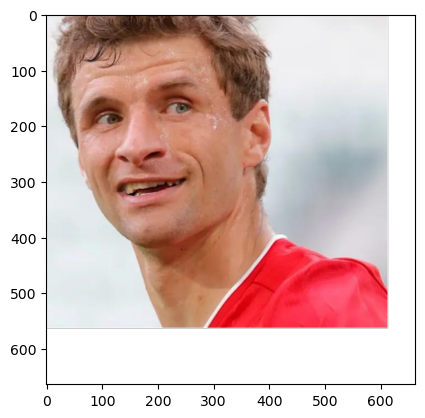

In [13]:
plt.imshow(translated_thomas)

## Rotation

In [14]:
def rotate_image_clockwise(image: np.ndarray, rotation_angle: float, rad=False, preserve_dim=True) -> np.ndarray:
    if not rad:
        rotation_angle = np.deg2rad(rotation_angle)

    translation_matrix = np.array(
        [
            [1, 0, -image.shape[1] // 2],
            [0, 1, -image.shape[0] // 2],
            [0, 0, 1]
        ]
    )
    rotation_matrix = np.array(
        [            
            [np.cos(rotation_angle), -np.sin(rotation_angle), image.shape[0] // 2], 
            [np.sin(rotation_angle), np.cos(rotation_angle), image.shape[1] // 2], 
            [0, 0, 1]
        ]
    )
    rotated_img = apply_transformations_on_image(img, [translation_matrix, rotation_matrix], preserve_dim)
    return rotated_img

### Plot the images

(664, 663, 4)

(664, 663, 4)

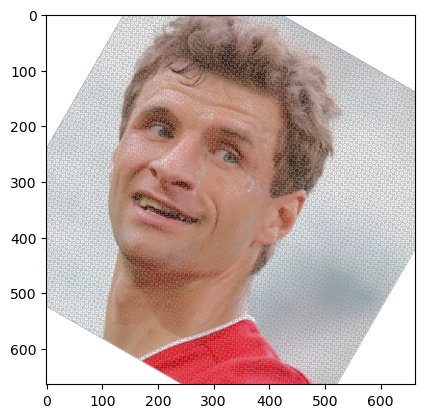

In [15]:
rotated_thomas = rotate_image_clockwise(img, -30, rad=False, preserve_dim=True)
display(img.shape)
display(rotated_thomas.shape)

plt.imshow(rotated_thomas)

### Affine

In [16]:
def affine(image: np.ndarray, A: np.ndarray, preserve_dim=True) -> np.ndarray:
    return apply_transformations_on_image(image, [A], preserve_dim)


### Plot the images

(664, 663, 4)

(664, 663, 4)

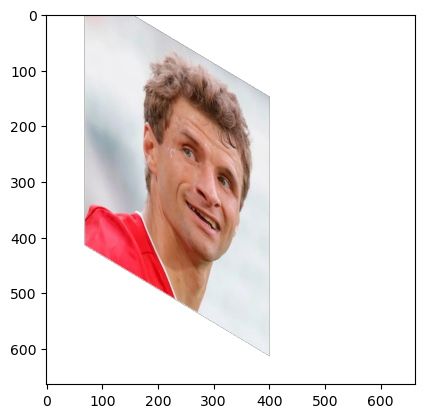

In [17]:
affine_matrix = np.array(
    [
        [-0.5, 0, 400],
        [0.3, 0.7, 50],
        [0, 0, 1]
    ]
)

thomas_affe = affine(img, affine_matrix, True)

display(img.shape)
display(thomas_affe.shape)

plt.imshow(thomas_affe)

### Projective

Load an image and make a projective transformation where you transform the x and y coordinates by an projective matrix formulation. Do NOT use opencv or other libraries for the transformation.
Please use numpy to process the image transformation.
Show the images with matplotlib side by side (original vs transformed).

Choose a random homography transformation matrix and apply it to the image.

In [18]:
def homography(image: np.ndarray, H: np.ndarray, preserve_dim=True) -> np.ndarray:
    return apply_transformations_on_image(image, [H], preserve_dim)


### Plot the images

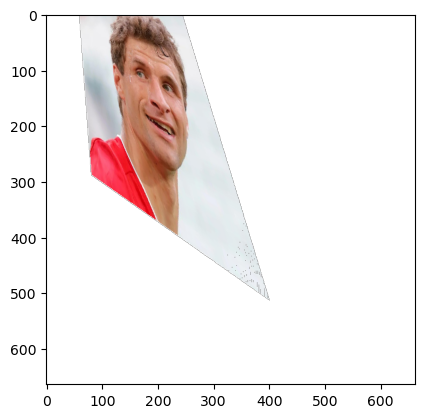

In [19]:
homography_matrix = np.array(
    [
        [-0.4, 0, 400],
        [0.05, 0.8, 150],
        [0.001, 0.001, 1]
    ]
)

thomas_transformed = homography(img, homography_matrix, True)

plt.imshow(thomas_transformed)

## Camera model and projections

In [45]:
def create_camera_intrinsics(fov: int, image_width: int, image_height: int) -> np.ndarray:
    diag = np.sqrt(image_width**2 + image_height**2)
    focal_length = (diag / 2) / (np.tan(np.deg2rad(fov)/2))
    intrinsics = np.array(
        [
            [focal_length, 0, image_width / 2],
            [0, focal_length, image_height / 2],
            [0, 0, 1]
        ]
    )
    return intrinsics


fov = 100
image_width, image_height = 640, 480, #720, 300
K = create_camera_intrinsics(fov=fov, image_width=image_width, image_height=image_height)

### Projections between coordinate systems

In [46]:
# Your code here
P = np.array(
    [
        [1, 0, 0, 0],
        [0, 0, -1, 0],
        [0, 1, 0, 0]
    ]
)

### Projection from a world point cloud into the camera image plane

In [47]:
import open3d as o3d  # pip install open3d (on your private computer, not on the THI computer)
import os

# Load the files as numpy array
def load_ply_files(file_dir: str) -> np.ndarray:
    # load all files from directory
    files = [f for f in os.listdir(file_dir) if f.endswith('.ply')]

    # load all files as numpy array
    data = []
    for file in files:
        data.append(np.asarray(o3d.io.read_point_cloud(os.path.join(file_dir, file)).points))
    
    return np.vstack(data)

### Visualization of the point clouds

In [48]:
# load files from plys directory
data = load_ply_files('./plys')


### From 3D to 2D

In [49]:
# Now it is time to project the points from the point cloud into our image plane
# As mentioned earlier, the camera is located at (0,0,0) and according to the coordinate system facing into the screen (forward)

# First, we need to transform the points from the world coordinate system to the camera coordinate system

# From world to camera
def world_to_camera(P: np.ndarray, points: np.ndarray) -> np.ndarray:
    points_4d = get_homogene_coords_from_inhomogene(points)
    return (P @ points_4d.T).T

In [50]:
test_data = np.array([
    [1, 2, 0],
    [3, 5, 2]
])
world_to_camera(P, test_data)

array([[ 1.,  0.,  2.],
       [ 3., -2.,  5.]])

In [51]:
# Second, from camera to image plane
def camera_to_image_plane(K: np.ndarray, points: np.ndarray, width: int, height: int) -> np.ndarray:
    image_coords_homogene = (K @ points.T).T
    inhomog = get_inhomogene_from_homogene_coords(image_coords_homogene)

    # Filter out coordinates that are outside of the image
    mask = (0 <= inhomog[..., 0]) & (inhomog[..., 0] < width) & (0 <= inhomog[..., 1]) & (inhomog[..., 1] < height)
    return image_coords_homogene[mask]

In [52]:
camera_coords = world_to_camera(P, data)
image = camera_to_image_plane(K, camera_coords, 200, 300)
1 / image[..., -1].max()

0.014197772393929758

### Plot the 3D to 2D projection (plot the image)

In [53]:
def map_value(value, old_min, old_max, new_min, new_max):
    return ((value - old_min) / (old_max - old_min)) * (new_max - new_min) + new_min

def image_coordinates_to_depth_image(image_coordinates: np.ndarray, width: int, height: int, max_depth: int = -1) -> np.ndarray:
    depths = 1 / image_coordinates[..., -1]
    depth_img = np.zeros((height, width))

    depth_mask = (0 <= image_coordinates[..., -1]) & (image_coordinates[..., -1] <= max_depth)
    depths = depths[depth_mask]
    
    filtered_coords = get_inhomogene_from_homogene_coords(image_coordinates[depth_mask])
    remapped_depths = map_value(depths, depths.min(), depths.max(), 0, 255)
    print(len(depths))
    for (coord_x, coord_y), depth in zip(filtered_coords, remapped_depths):
        depth_img[coord_y, coord_x] = depth

    return depth_img


In [54]:
image_coordinates = camera_to_image_plane(K, world_to_camera(P, data), image_width, image_height)
max_depth = 255
height = image_height
width = image_width



###
depths = 1 / image_coordinates[..., -1]
depth_img = np.zeros((height, width))

depth_mask = (0 <= image_coordinates[..., -1]) & (image_coordinates[..., -1] <= max_depth)
depths = depths[depth_mask]

filtered_coords = get_inhomogene_from_homogene_coords(image_coordinates[depth_mask])

filtered_coords.shape

(167760, 2)

167760


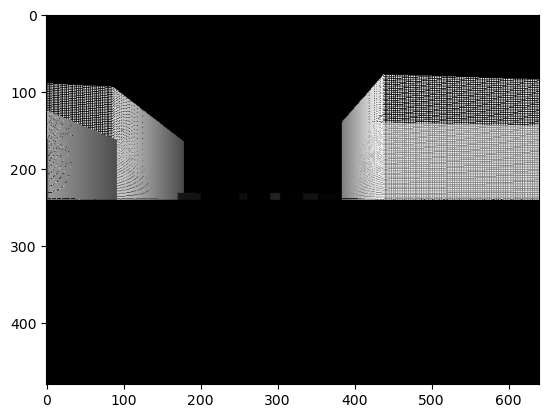

In [55]:
image_coordinates = camera_to_image_plane(K, world_to_camera(P, data), image_width, image_height)

plt.imshow(image_coordinates_to_depth_image(image_coordinates, image_width, image_height, 255), cmap='gray')
plt.show()